Using trained model for Vechile detection 

In [40]:
import numpy as np
import model
from scipy.ndimage.measurements import label
import cv2
import os.path

print("Done")

Done


Read input frame without car 

In [41]:
frame_no_car = cv2.imread('frame0.jpg',3)
cv2.imshow('image',frame_no_car)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [46]:
frame_car1 = cv2.imread('frame1000.jpg',3)
cv2.imshow('image',frame_car1)
cv2.waitKey(0)
cv2.destroyAllWindows()

The region of interest for vehicle detection starts at an approximately 400th pixel from the top and spans vertically for about 260 pixels. That said, we have a region of interest with the dimensions of 260x1280x3, where 3 is the number of color channels, starting at 400th pixel vertically.
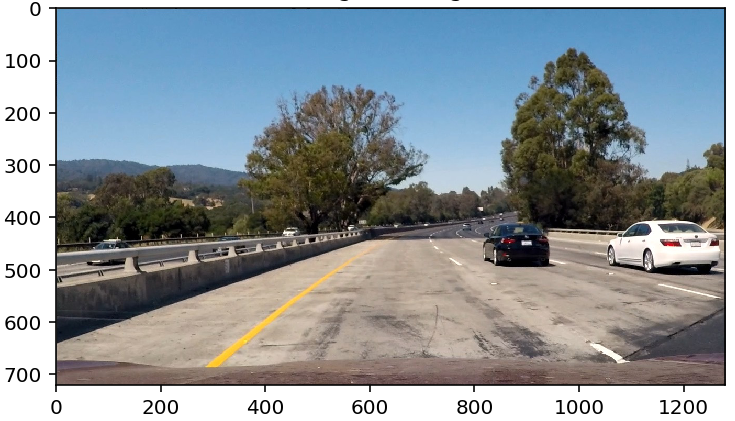

In [26]:
crop=(400, 660)
imgInputShape=(720, 1280, 3)
bottomClip = imgInputShape[0] - crop[1]
inH = imgInputShape[0] - crop[0] - bottomClip
inW = imgInputShape[1]
inCh = imgInputShape[2]
print('inW',inW, ' ', 'inCh',inCh,' ','inH',inH)              

inW 1280   inCh 3   inH 260


In [27]:
cnnModel,cnnModelName=model.poolerPico(inputShape=(inH, inW, inCh))
cnnModel.load_weights('{}.h5'.format(cnnModelName))


The top convolutional layer now has the dimensionality of (? ,25, 153, 1), where 25x53 actually represents a miniature map of predictions that will ultimately be projected to the original hi-res image.

In [28]:
cnnModel.summary()
cnnModelName


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 260, 1280, 3)      0         
_________________________________________________________________
cv0 (Conv2D)                 (None, 260, 1280, 16)     448       
_________________________________________________________________
dropout_4 (Dropout)          (None, 260, 1280, 16)     0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 260, 1280, 32)     4640      
_________________________________________________________________
dropout_5 (Dropout)          (None, 260, 1280, 32)     0         
_________________________________________________________________
cv2 (Conv2D)                 (None, 260, 1280, 64)     18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 160, 64)       0         
__________

'ppico'

Obtain the ROI from input image

In [47]:
roi= frame_car1[crop[0]:crop[1],:]
roi
cv2.imshow('Cropped',roi)
cv2.waitKey(0)
cv2.destroyAllWindows()

ROI is obtained 
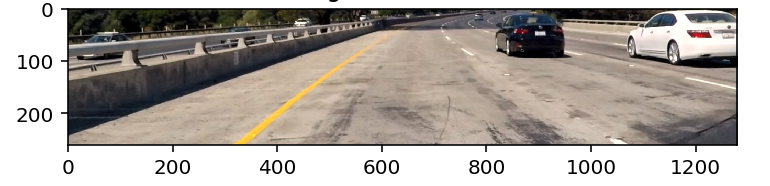

In [30]:
roiW, roiH = roi.shape[1], roi.shape[0]
roiW , roiH

(1280, 260)

In [31]:
# Going 4-D
roi = np.expand_dims(roi, axis=0)

# Single-Feature top convolutional layer, which represents a
# miniaturized (25x153) version of the ROI with the vehicle's probability at each point
detectionMap = cnnModel.predict(roi)
detectionMap


array([[[[5.9501699e-04],
         [6.6978246e-04],
         [2.0230282e-03],
         ...,
         [5.1967281e-01],
         [9.0813065e-01],
         [8.9557505e-01]],

        [[2.3579902e-04],
         [1.5181024e-04],
         [1.9854130e-04],
         ...,
         [9.5699340e-01],
         [9.9788672e-01],
         [9.9815530e-01]],

        [[9.3317780e-05],
         [9.0293048e-05],
         [7.9577942e-05],
         ...,
         [9.1399634e-01],
         [9.9113768e-01],
         [9.9854350e-01]],

        ...,

        [[1.1876919e-02],
         [8.1976475e-03],
         [5.6965919e-03],
         ...,
         [2.4859210e-02],
         [2.3544349e-02],
         [2.3016497e-02]],

        [[1.1448142e-02],
         [9.3642250e-03],
         [9.2958137e-03],
         ...,
         [2.5712144e-02],
         [2.7567841e-02],
         [2.8327381e-02]],

        [[1.3626013e-02],
         [1.8201223e-02],
         [2.3568133e-02],
         ...,
         [3.0811863e-02],
        

In [32]:
detectionMap.shape

(1, 25, 153, 1)

Detection Map is obtained 

In [33]:
detectionMap.shape[1], detectionMap.shape[2]

(25, 153)

In [34]:
predictionMapH, predictionMapW = detectionMap.shape[1], detectionMap.shape[2]

ratioH, ratioW = roiH / predictionMapH, roiW / predictionMapW
ratioH, ratioW

(10.4, 8.366013071895425)

In [35]:
 # Prediction output is 4-D tensor: (1, H, W, 1) in this particular case,
#thus converting to 2-D, effectively represents it as a single-channel image
detectionMap = detectionMap.reshape(detectionMap.shape[1], detectionMap.shape[2])
detectionMap.shape

(25, 153)

In [36]:
confidenceThrd=.7
diagKernel = [[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]]
#defines feature connections. Here 8 connectivity 

In [37]:
detectionMap = detectionMap > confidenceThrd
labels = label(detectionMap, structure= diagKernel)
labels

(array([[0, 0, 0, ..., 0, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 3)

Label indicated features labelled in total 

To draw the boxes for the frames 

In [38]:
hotPoints = []
detectionPointSize = 64

        # Considering obtained labels as vehicles.
for vehicleID in range(labels[1]):
    nz = (labels[0] == vehicleID + 1).nonzero()
    nzY = np.array(nz[0])
    nzX = np.array(nz[1])

    # +/-'s are manually derived adjustments for more appropriate boxes visualization
    xMin = np.min(nzX) - 32
    xMax = np.max(nzX) + 32

    yMin = np.min(nzY)
    yMax = np.max(nzY) + 64

    # Used to keep generated bounding boxes within a range of the label (a.k.a. vehicle) boundaries
    spanX = xMax - xMin
    spanY = yMax - yMin

    for x, y in zip(nzX, nzY):

        # Adjustment offsets for a box starting point.
        # Ranges from 0 for the left(upper)-most to detectionPointSize for right(bottom)-most
        offsetX = (x - xMin) / spanX * detectionPointSize
        offsetY = (y - yMin) / spanY * detectionPointSize

        # Getting boundaries in ROI coordinates scale (multiplying by ratioW, ratioH)
        topLeftX = int(round(x * ratioW - offsetX, 0))
        topLeftY = int(round(y * ratioH - offsetY, 0))
        bottomLeftX = topLeftX + detectionPointSize
        bottomLeftY = topLeftY + detectionPointSize

        topLeft = (topLeftX, crop[0] + topLeftY)
        bottomRight = (bottomLeftX, crop[0] + bottomLeftY)

        hotPoints.append((topLeft, bottomRight))
        
hotPoints

[((799, 400), (863, 464)),
 ((807, 400), (871, 464)),
 ((814, 400), (878, 464)),
 ((822, 400), (886, 464)),
 ((829, 400), (893, 464)),
 ((837, 400), (901, 464)),
 ((844, 400), (908, 464)),
 ((852, 400), (916, 464)),
 ((859, 400), (923, 464)),
 ((867, 400), (931, 464)),
 ((792, 409), (856, 473)),
 ((799, 409), (863, 473)),
 ((807, 409), (871, 473)),
 ((814, 409), (878, 473)),
 ((822, 409), (886, 473)),
 ((829, 409), (893, 473)),
 ((837, 409), (901, 473)),
 ((844, 409), (908, 473)),
 ((852, 409), (916, 473)),
 ((859, 409), (923, 473)),
 ((867, 409), (931, 473)),
 ((784, 419), (848, 483)),
 ((792, 419), (856, 483)),
 ((799, 419), (863, 483)),
 ((807, 419), (871, 483)),
 ((814, 419), (878, 483)),
 ((822, 419), (886, 483)),
 ((829, 419), (893, 483)),
 ((837, 419), (901, 483)),
 ((844, 419), (908, 483)),
 ((852, 419), (916, 483)),
 ((859, 419), (923, 483)),
 ((867, 419), (931, 483)),
 ((784, 428), (848, 492)),
 ((792, 428), (856, 492)),
 ((799, 428), (863, 492)),
 ((807, 428), (871, 492)),
 

Generating Heat Maps from the hot points obtained from the detection Maps 

Obtaining the Heat Map 

In [48]:
src= frame_car1
sampleMask = np.zeros_like(src[:, :, 0]).astype(np.float)
bBoxes=hotPoints
mask=sampleMask
for box in bBoxes:
        # box as ((x, y), (x, y))
        topY = box[0][1]
        bottomY = box[1][1]
        leftX = box[0][0]
        rightX = box[1][0]

        mask[topY:bottomY, leftX:rightX] += 1

        mask = np.clip(mask, 0, 255)
        
heatMap = mask 
        
cv2.imshow('heat',heatMap)
cv2.waitKey(0)
cv2.destroyAllWindows()